Import necessary libraries below

In [21]:
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
import time
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

Define plotting options

In [22]:
%matplotlib inline
plt.style.use("ggplot")

Explore the existing data, finding the paths to the available dataset companies

In [23]:
csv_files = list(glob.glob("*stock_market_data/sp500/csv/*.csv", recursive = True))
csv_files[:5]

['stock_market_data\\sp500\\csv\\A.csv',
 'stock_market_data\\sp500\\csv\\AAL.csv',
 'stock_market_data\\sp500\\csv\\AAP.csv',
 'stock_market_data\\sp500\\csv\\AAPL.csv',
 'stock_market_data\\sp500\\csv\\ABBV.csv']

Define below creation of different models through functions in Python

In [24]:
def create_best_cnn_model(input_shape):
    # CNN model
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(input_shape,1)))
    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(Dense(1))  # Output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mape'])
    return model

Store the paths to all the companies we have in our dataset

In [25]:
prices_dict_path = {}

for file in csv_files:
    splits_of_path = file.split("\\")
    company_part = splits_of_path[-1].split(".csv")[0]
    prices_dict_path[company_part] = file

Define plotting function to show results in training for the metrics used in training vs validation

In [26]:
def plot_graph(epochs, validation_values, train_values, metric):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_values, 'b', label=f'Training {metric}')
    plt.plot(epochs, validation_values, 'r', label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

Create two different training functions: one for the user to manually train a configuration, which will allow the user to visualize the validation vs training and one to use in the evolutionary process, as that would not require plotting graphs, making it lightweight and also allowing for an early stop. The individual params lets the user pass in manual_training the configuration of the network, if not it will just use the default best.

In [27]:
def manual_training_for_company(company_name, model_creation, scaler, individual_params=None):
    csv_path = prices_dict_path[company_name]
    data = pd.read_csv(csv_path, delimiter=',', usecols=['Open', 'High', 'Low', 'Close', 'Volume'])
    epochs = 300
    epoch_points = range(1,epochs+1)
    
    # It is important to scale values in the training data, as this helps in improving the accuracy o the prediction values, helping use achieve
    # results closer to the real values. We use minmaxscaler, which will transform to follow a normal distribution.
    X = scaler.fit_transform(data)
    X = X[:-1]
    y = data['Close']
    y = y[1:]
    # this is following Train-Validation Split., where we perform validation on unseen data and try to evaluate the performance of the model.
    # it is important that we avoid problems such as overfitting when training the neural network.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Reshape data for CNN input
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    
    model = model_creation(X_train.shape[1]) if individual_params is None else model_creation(X_train.shape[1],individual_params)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=50, validation_data=(X_val, y_val), verbose = 0)
    
    # Plot MAE
    plot_graph(epoch_points, history.history['val_mape'], history.history['mape'], 'MAPE')
    
    # Plot losses
    plot_graph(epoch_points, history.history['val_loss'], history.history['loss'], "LOSS")
    
    return history.history['val_mape'][-1], model

Trying


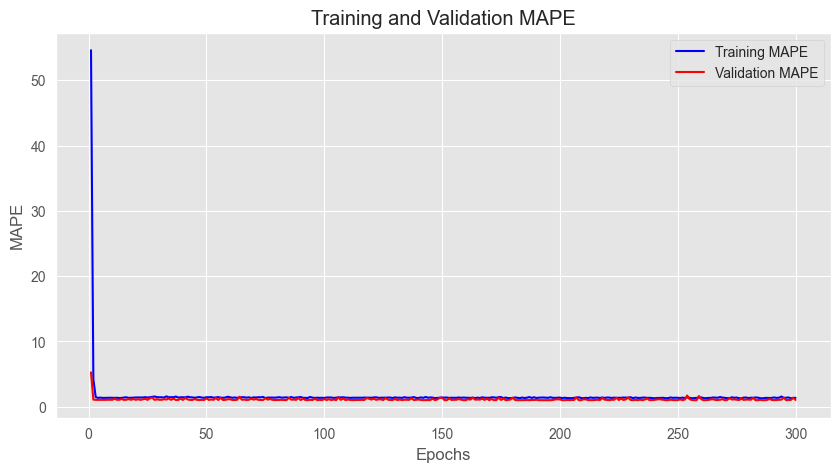

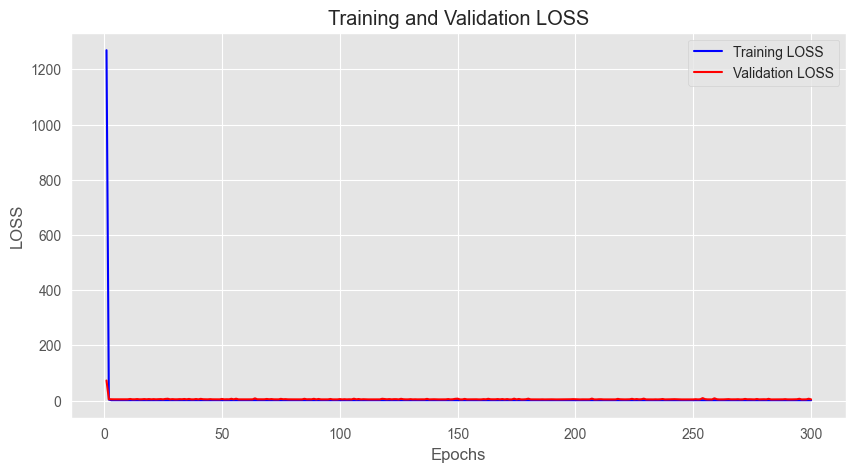

In [28]:
# For running the manual_training we can do something like the code below
print("Trying")
scaler = MinMaxScaler()
_,model = manual_training_for_company("IBM", create_best_cnn_model, scaler)

Creating a function to be able to evaluate on new data, that is not in our dataset.

In [29]:
def predict_and_evaluate_on_new_data(expected_prices, input_data, model, scaler):
    results = np.array(expected_prices)
    scaled_prediction_point = scaler.transform(input_data)
    scaled_prediction_point = np.reshape(scaled_prediction_point, (scaled_prediction_point.shape[0], scaled_prediction_point.shape[1], 1))
    predictions = model.predict(scaled_prediction_point)
    print(predictions)
    model.evaluate(scaled_prediction_point, results)

In [30]:
# How this function could be used is shown below:
microsoft_dict = pd.DataFrame({
    'Low': [377.44, 367.35, 326.36, 310.02, 319.21, 345.07, 333.45, 309.83, 285.67, 269.52, 366.32],
    'Open': [383.76, 371.01, 332.38, 315.13, 320.26, 347.11, 334.36, 309.83, 287.23, 274.88, 368.23],
    'Volume': [28942500, 27683900, 21072400, 26297600, 24342600, 41637700, 23084700, 26730300, 25824300, 34558700, 23099800],
    'High': [384.30, 371.95, 333.83, 315.88, 322.41, 351.89, 337.96, 313.71, 290.45, 275.00, 371.45],
    'Close': [378.85, 370.27, 327.73, 312.14, 321.01, 350.98, 335.02, 311.74, 287.18, 273.78, 370.95]
})
results_for_microsoft = [380, 369.67, 328.65, 312.79, 324.04, 337.77, 328.60, 314.00, 284.34, 272.29, 372]
predict_and_evaluate_on_new_data(results_for_microsoft, microsoft_dict, model, scaler)

1/1 [==============================] - 0s 55ms/step
[[382.1634 ]
 [372.4518 ]
 [330.44342]
 [314.30792]
 [322.9585 ]
 [353.07916]
 [337.4765 ]
 [313.94012]
 [289.39938]
 [274.95477]
 [372.4804 ]]
1/1 [==============================] - 0s 269ms/step - loss: 33.2004 - mape: 1.1660


In [31]:
apple_dict = pd.DataFrame({
              'Low':
                  [129.64, 189.25, 134.13, 150.85, 152.88, 133.77, 150.10, 165.54, 170.76, 192.55, 193.59, 193.67, 191.42],
              'Open':
                  [130.92, 190.87, 134.83, 152.35, 153.11, 134.08, 151.28, 165.80, 170.98, 196.02, 193.63, 194.20, 193.11],
              'Volume':
                  [63814900, 24048300, 63646600, 59144100, 65573800, 58280400, 73695900, 47720200, 113316400, 47460200, 47477700, 53377300, 60896700],
              'High':
                  [132.42, 190.90, 137.29, 153.00, 155.50, 136.25, 153.40, 168.16, 174.30, 197.20, 195.00, 195.99, 193.49],
              'Close':
                  [131.86, 189.97, 135.94, 152.55, 155.33, 135.27, 152.59, 167.63, 173.57, 193.22, 194.27, 195.71, 193.18]
             })
results_for_apple = [129.31, 189.79, 135.21, 148.48, 153.71, 137.87, 152.99, 166.65, 173.50, 195.32, 195.71, 193.12, 193.4]
predict_and_evaluate_on_new_data(results_for_apple, apple_dict, model, scaler)

1/1 [==============================] - 0s 24ms/step
[[133.50209]
 [190.79266]
 [137.95422]
 [154.33513]
 [157.30168]
 [137.06364]
 [154.90854]
 [169.08699]
 [177.66731]
 [195.74329]
 [196.25714]
 [197.59006]
 [195.34467]]
1/1 [==============================] - 0s 23ms/step - loss: 9.6285 - mape: 1.6615


In [32]:
palantir_dict = pd.DataFrame({
              'Low':
                  [5.74	],
              'Open':
                  [5.92	],
              'Volume':
                  [1652700],
              'High':
                  [6.15],
              'Close':
                  [5.81]
             })

predict_and_evaluate_on_new_data([6.10], palantir_dict, model, scaler)

1/1 [==============================] - 0s 20ms/step
[[6.3781896]]
1/1 [==============================] - 0s 25ms/step - loss: 0.0774 - mape: 4.5605


In [33]:
pltr_stock = pd.DataFrame({
              'Low':
                  [17.08, 17.05, 17.93	],
              'Open':
                  [17.22, 17.69, 18.99	],
              'Volume':
                  [56216900, 96111000, 79952600],
              'High':
                  [17.48, 17.83, 19.08],
              'Close':
                  [17.22, 17.13, 18.54]
             })

In [34]:
import yfinance as yf
from pandas import DataFrame

# Ticker symbol for the stock
def get_dataframe_for_ticker(ticker_symbol: str) -> DataFrame:
    # Fetch stock data
    stock_data = yf.Ticker(ticker_symbol)
    # Get historical market data
    historical_data = stock_data.history(period="max")
    return historical_data
apps_df = get_dataframe_for_ticker("APPS")
print(apps_df)

def second_manual_training_for_company(dataframe, model_creation, scaler, individual_params=None):
    data = dataframe[['Open', 'High', 'Low', 'Close', 'Volume']]
    epochs = 500
    epoch_points = range(1,epochs+1)
    
    # It is important to scale values in the training data, as this helps in improving the accuracy o the prediction values, helping use achieve
    # results closer to the real values. We use minmaxscaler, which will transform to follow a normal distribution.
    X = scaler.fit_transform(data)
    X = X[:-1]
    y = data['Close']
    y = y[1:]
    # this is following Train-Validation Split., where we perform validation on unseen data and try to evaluate the performance of the model.
    # it is important that we avoid problems such as overfitting when training the neural network.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Reshape data for CNN input
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    
    model = model_creation(X_train.shape[1]) if individual_params is None else model_creation(X_train.shape[1],individual_params)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=50, validation_data=(X_val, y_val), verbose = 0)
    
    # Plot MAE
    #plot_graph(epoch_points, history.history['val_mape'], history.history['mape'], 'MAPE')
    
    # Plot losses
    #plot_graph(epoch_points, history.history['val_loss'], history.history['loss'], "LOSS")
    
    return history.history['val_mape'][-1], model
second_manual_training_for_company(apps_df, create_best_cnn_model, scaler)

                           Open  High   Low  Close   Volume  Dividends  \
Date                                                                     
2006-07-06 00:00:00-04:00  2.10  2.10  2.10   2.10     2100        0.0   
2006-07-07 00:00:00-04:00  2.20  2.20  2.10   2.20     2000        0.0   
2006-07-10 00:00:00-04:00  2.20  2.20  2.20   2.20        0        0.0   
2006-07-11 00:00:00-04:00  2.20  2.20  2.20   2.20      450        0.0   
2006-07-12 00:00:00-04:00  2.20  2.20  2.20   2.20     3950        0.0   
...                         ...   ...   ...    ...      ...        ...   
2023-12-18 00:00:00-05:00  6.60  6.95  6.55   6.82  1779800        0.0   
2023-12-19 00:00:00-05:00  6.95  7.33  6.94   7.06  2030300        0.0   
2023-12-20 00:00:00-05:00  7.00  7.02  6.61   6.64  2253900        0.0   
2023-12-21 00:00:00-05:00  6.83  6.93  6.67   6.89  1508800        0.0   
2023-12-22 00:00:00-05:00  6.83  6.93  6.84   6.84    17025        0.0   

                           Stock Spli

(4.671489715576172, <keras.src.engine.sequential.Sequential at 0x1f970a9c510>)

In [35]:
import random

def create_general_cnn_model(input_shape, individual_params):
    model = Sequential()
    model.add(Conv1D(filters=individual_params['number_of_filters'], 
                     kernel_size= individual_params['kernel_size'], 
                     activation= individual_params['activation_in_convolution'], 
                     input_shape=(input_shape,1)))
    model.add(Flatten())
    model.add(Dense(individual_params['nodes_in_dense_layer'], activation=individual_params['activation_in_dense_layer']))
    model.add(Dense(1))  # Output layer
    # Compile the model
    model.compile(optimizer=individual_params['optimizer'], loss=individual_params['loss'], metrics=['mape'])
    return model

# Define the range of values for each hyperparameter
hyperparameter_ranges = {
    'number_of_filters': list(range(32, 1024)),
    'kernel_size': list(range(1, 6)),
    'activation_in_convolution': ['relu', 'sigmoid', 'tanh', 'linear', 'swish'],
    'activation_in_dense_layer': ['relu', 'linear', 'swish'],
    'nodes_in_dense_layer': list(range(10, 1024)),
    'optimizer': ['adam', 'rmsprop', 'sgd', "adagrad"],
    'loss': ['mean_squared_error', 'mean_absolute_error', 'huber_loss']
}

def evaluate_fitness(current_individual):
    scaler = MinMaxScaler()
    try:
        start_time = time.time()
        fitness, _ = second_manual_training_for_company(apps_df, create_general_cnn_model, scaler, current_individual)
        print(f"A valid configuration that ran was {current_individual}. Fitness is {fitness}. Training the model took {time.time() - start_time} seconds")
        return fitness
    except Exception as e:
        print(f"An invalid configuration was {current_individual}, with error {e}")
        return float('inf')
    
def generate_individual():
    # Randomly sample values for each hyperparameter
    hyperparameters = {
        key: random.choice(value) for key, value in hyperparameter_ranges.items()
    }
    return hyperparameters

# Function to perform mutation on discrete hyperparameters
def mutate_parameters(current_params, mutation_probability):
    mutated_params = current_params.copy()  # Copy current parameters
    for key, values in hyperparameter_ranges.items():
        if random.uniform(0,1) < mutation_probability:
            value_to_assign = random.choice(values)
            mutated_params[key] = value_to_assign
    return mutated_params

# (1+1) Evolution Strategy for discrete hyperparameters with a reset mechanism
def one_plus_one_ES(initial_params, max_iterations, reset_threshold, mutation_probability):
    current_params = initial_params.copy()  # Initial set of parameters
    current_fitness = evaluate_fitness(current_params)  # Evaluate fitness
    no_progress_counter = 0  # Counter to track iterations without progress

    for iteration in range(max_iterations):
        # Mutate the current parameters
        mutated_params = mutate_parameters(current_params, mutation_probability)

        # Evaluate fitness of mutated parameters
        mutated_fitness = evaluate_fitness(mutated_params)

        # Compare fitness of mutated parameters with current fitness
        if mutated_fitness <= current_fitness:
            print(f"Found a new best solution with fitness {mutated_fitness} for neural network {mutated_params}")
            current_params = mutated_params
            current_fitness = mutated_fitness
            no_progress_counter = 0  # Reset no progress counter
        else:
            no_progress_counter += 1

        # Reset if no progress after a certain threshold
        if no_progress_counter >= reset_threshold:
            current_params = generate_individual()
            current_fitness = evaluate_fitness(current_params)
            no_progress_counter = 0  # Reset no progress counter

    return current_params, current_fitness


iterations = 10000
initial_individual = generate_individual()
mutation_probability = 0.3
reset_threshold = 15
current_params, current_fitness = one_plus_one_ES(initial_individual, iterations, reset_threshold, mutation_probability)
print("Best params ", current_params, " best fitness ", current_fitness)

A valid configuration that ran was {'number_of_filters': 1000, 'kernel_size': 3, 'activation_in_convolution': 'relu', 'activation_in_dense_layer': 'swish', 'nodes_in_dense_layer': 907, 'optimizer': 'sgd', 'loss': 'huber_loss'}. Fitness is 4.525577068328857. Training the model took 355.8127295970917 seconds
A valid configuration that ran was {'number_of_filters': 1000, 'kernel_size': 4, 'activation_in_convolution': 'relu', 'activation_in_dense_layer': 'swish', 'nodes_in_dense_layer': 907, 'optimizer': 'adam', 'loss': 'huber_loss'}. Fitness is 8.391334533691406. Training the model took 619.02197432518 seconds
A valid configuration that ran was {'number_of_filters': 1000, 'kernel_size': 3, 'activation_in_convolution': 'relu', 'activation_in_dense_layer': 'swish', 'nodes_in_dense_layer': 907, 'optimizer': 'sgd', 'loss': 'huber_loss'}. Fitness is 4.588301181793213. Training the model took 520.9966127872467 seconds
A valid configuration that ran was {'number_of_filters': 1000, 'kernel_size':

KeyboardInterrupt: 